# Libraries Import

In [1]:
# LIBRARIES IMPORT

# for working with dataframes, CSV
import pandas as pd

# for working with twitter API
import tweepy

# for working with wrapping python codes into SQL queries
import sqlalchemy as db

# for getting current date and time for CSV file creation
from datetime import datetime

# for keeping credentials out of sight
import os
from dotenv import load_dotenv

# for sentiment analysis
from textblob import TextBlob

# for removing URLs and @mentions in tweets
import re

# for stopwords
import nltk
from nltk.corpus import stopwords
import itertools
import collections

# For generating word cloud
from wordcloud import WordCloud
import numpy as np

# for plotting wordcloud and sentiments analysis pie chart
import matplotlib.pyplot as plt
from PIL import Image

# Credentials and Authorization

In [2]:
# establish working directory path
# getcwd() returns current working directory
wdir_path = os.getcwd()

### Twitter Credentials

In [3]:
# create a "twitter-keys.env" file under the script working directory
# fill in personal api keys and access tokens and save

twitter_path = os.path.join(wdir_path, "twitter-keys.env") # absolute path of "twitter-keys.env"
# load the credentials into os environment 
load_dotenv(twitter_path)
#check if credentials loaded successfully
os.environ


# Credentials obtained from twitter developer account to access API
# getting api_keys & access_tokens from "twitter-keys.env"
consumer_key = os.getenv("consumer_key")
consumer_secret = os.getenv("consumer_secret")
access_key = os.getenv("access_key")
access_secret = os.getenv("access_secret")

# setup Twitter API connection details
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

### SQL Credentials

In [4]:
# create a "sql-keys.env" file under the script working directory
# fill in personal api keys and access tokens and save
sql_path = os.path.join(wdir_path, "sql-keys.env") # absolute path of "sql-keys.env"
# load the credentials into os environment 
load_dotenv(sql_path)
#check if credentials loaded successfully
os.environ

# getting credentials information from "sql-keys.env"
user = os.getenv("dbUser")
password = os.getenv("dbPwd")
hostname = os.getenv("dbHost")
port_no = os.getenv("dbPort")
db_name = os.getenv("dbName")

# setup connection engine details
engine = db.create_engine(f"postgresql://{user}:{password}@{hostname}:{port_no}/{db_name}")  

# Create Table in PostgreSQL

In [5]:
# Create connection engine
conn = engine.raw_connection()

# Create new tables in PostgreSQL
commands = ("""CREATE TABLE IF NOT EXISTS twitterDatabase (tweet_id BIGINT PRIMARY KEY,
                                                           username VARCHAR(15),
                                                           display_name TEXT,
                                                           location TEXT,
                                                           followers_count INTEGER,
                                                           following_count INTEGER,
                                                           tweet_text TEXT,
                                                           hashtags TEXT,
                                                           polarity NUMERIC(3,2),
                                                           subjectivity NUMERIC(3,2));""")

# Initialize connection to PostgreSQL
cur = conn.cursor()
table_count = 0

# Create cursor to execute SQL commands
cur.execute(commands)
table_count += 1

# Close communication with server
conn.commit()
cur.close()
conn.close()

print(str(table_count),"table(s) have been created in PostgreSQL.")

1 table(s) have been created in PostgreSQL.


# Data Extraction

Creation of queries using Tweepy API

Function is focused on completing the query then providing a CSV file of that query using pandas

And then inserting the data directly into PostgreSQL database

In [6]:
# function to display data of each tweet
def printtweetdata(n, ith_tweet):
        print()
        print(f"====Tweet {n}====")
        print(f"Tweet ID:{ith_tweet[0]}")
        print(f"Userame:{ith_tweet[1]}")
        print(f"Display Name:{ith_tweet[2]}")
        print(f"Location:{ith_tweet[3]}")
        print(f"Follower Count:{ith_tweet[4]}")
        print(f"Following Count:{ith_tweet[5]}")
        print(f"Tweet Text:{ith_tweet[6]}")
        print(f"Hashtags Used:{ith_tweet[7]}")
        print(f"Polarity:{ith_tweet[8]}")
        print(f"Subjectivity:{ith_tweet[9]}")

# function to perform data extraction
def scrape(words, numtweet):

        # Creating DataFrame using pandas
        global tweetsDF
        tweetsDF = pd.DataFrame(columns=["tweet_id",
                                   "username",
                                   "display_name",
                                   "location",
                                   "followers",
                                   "following",
                                   "text",
                                   "hashtags",
                                   'polarity',
                                   'subjectivity'])

        # We are using .Cursor() to search through twitter for the required tweets.
        # The number of tweets can be restricted using .items(number of tweets)
        if inp == "1": # if user input to search using hashtag
            tweets = tweepy.Cursor(api.search_tweets,
                                   words,
                                   lang="en",
                                   tweet_mode="extended").items(numtweet)
        elif inp == "2": # if user input to search using username
            tweets = tweepy.Cursor(api.user_timeline,
                                   screen_name=words,
                                   tweet_mode="extended").items(numtweet)
                
        
        # .Cursor() returns an iterable object.
        # Each item in the iterator has various attributes
        # that you can access to get information about each tweet
        list_tweets = [tweet for tweet in tweets]
        
        # we will iterate over each tweet in the list for extracting information about each tweet
        val = []
        for i, tweet in enumerate(list_tweets, 1):
            tweet_id = tweet.id
            username = tweet.user.screen_name
            display_name = tweet.user.name
            location = tweet.user.location
            followers = tweet.user.followers_count
            following = tweet.user.friends_count
            hashtags = tweet.entities["hashtags"]
            
            # Retweets can be distinguished by a retweeted_status attribute,
            # in case it is an invalid reference, except block will be executed
            try:
                text = tweet.retweeted_status.full_text
            except AttributeError:
                text = tweet.full_text
            
            # Sentiment analysis
            polarity = round(TextBlob(text).sentiment[0], 2)
            subjectivity = round(TextBlob(text).sentiment[1], 2)            
            
            # extracting all hashtags in the tweet
            # because there may be multiple hashtags in a tweet
            hashtext = list()            
            for j in range(0, len(hashtags)):
                hashtext.append(hashtags[j]["text"])
                
            # Here we are appending all the extracted information in the DataFrame
            ith_tweet = [tweet_id, username,
                         display_name, location,
                         followers, following,
                         text, hashtext,
                         polarity, subjectivity]
            tweetsDF.loc[len(tweetsDF)] = ith_tweet

            # Function call to print tweet data on screen
            printtweetdata(i, ith_tweet)
            val.append(ith_tweet)
        
        
        # we will save our database as a CSV file.
        # depending on user's input to search by hashtag or username
        # CSV filename generated will be different
        if inp == "1": # if user input to search using hashtag
            tweetsDF.to_csv("hashtag-{}-tweets_{}.csv".format(words, datetime.now().strftime("%Y-%m-%d_%H%M%S")), sep=",", index=False)
        elif inp == "2": # if user input to search using username
            tweetsDF.to_csv('{}-tweets_{}.csv'.format(username, datetime.now().strftime("%Y-%m-%d_%H%M%S")), sep=',', index=False)
        

        # SQL command to insert scrapped tweet data into PostgreSQL database
        sql = """
        INSERT INTO twitterDatabase(tweet_id, username, display_name, location, followers_count, following_count,
        tweet_text, hashtags, polarity, subjectivity)
        VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s
        ) ON CONFLICT(tweet_id) DO NOTHING
        """
        
        # Create connection engine
        conn = engine.raw_connection()
        
        # Initialize connection to PostgreSQL
        cur = conn.cursor()
        
        # Create cursor to execute SQL commands
        cur.executemany(sql, val)
        
        # print message when scrape is successful
        print("\nScraping has completed!")

        # Close communication with server
        conn.commit()
        cur.close()
        conn.close()      
        

# User Search Query

Querying user if they want to search by hashtag or username

Then querying for user's input based on their choice

In [7]:
# function for user search query
def search_input():

    # To make sure user enters only valid inputs; must be alphanumeric.
    while True:
        try:
            words = input()
            # If input is empty
            if not words:
                raise ValueError("You did not enter anything. Please try again.")
            # If input does not contain only alphanumeric.
            elif not words.isalnum():
                raise ValueError("Only alphanumeric allowed. Please try again.")
            break
        except ValueError as e: # to catch any other errors.
            print(e)

    numtweet = 100

    print("\nLoading, please wait......")
    
    scrape(words, numtweet)
    
# function to query if user wants to search by hashtag or username
def one_or_two():
    # asking user how they want to search
    print("Do you want to:\n1) Search by a hashtag, or\n2) Search by a username?")
    global inp # declaring this inp as global so it can be used to check user's input in other functions
    inp = input()
    if inp == "1": # if user choose to search by hashtag
        print("Enter Twitter HashTag to search for.")
        search_input()
    elif inp == "2": # if user to choose to search by username
        print("Enter Twitter Username to search for.")
        search_input()
    else: # if user did not input 1 or 2
        print("You must choose between 1 or 2\n")
        return one_or_two()
one_or_two()   

Do you want to:
1) Search by a hashtag, or
2) Search by a username?
1
Enter Twitter HashTag to search for.
StandWithUkraine

Loading, please wait......

====Tweet 1====
Tweet ID:1508333599149502465
Userame:HonzaStefan
Display Name:Jan Stefan
Location:
Follower Count:7
Following Count:600
Tweet Text:In the Kharkiv metro animators calm down children who are hiding from the Russian army
#StandWithUkraine https://t.co/3QjJ9kJXUK
Hashtags Used:['StandWithUkraine']
Polarity:0.05
Subjectivity:0.35

====Tweet 2====
Tweet ID:1508333587564662784
Userame:roens
Display Name:roens
Location:California, USA
Follower Count:460
Following Count:400
Tweet Text:Every broken house and every broken life is counted and accounted for. #Russia will pay. In hard currency. In reparations. To #Ukraine and all the ose that #StandWithUkraine The bill is growing and the case is strong
Hashtags Used:['Russia']
Polarity:-0.16
Subjectivity:0.52

====Tweet 3====
Tweet ID:1508333577146187780
Userame:Meglem3
Display Name:


====Tweet 52====
Tweet ID:1508332994980839425
Userame:iamoyegun
Display Name:Spectre
Location:Here and There
Follower Count:2652
Following Count:5001
Tweet Text:Yesterday, a British journalist asked me about evidence that Russians have committed war crimes against Ukrainians. 

Well, here is my answer. 

#FreeUkraine #WeAreAllUkrainians #StandWithUkraine #StopTheWar #United #StandTogether #StopWar #Ukraine https://t.co/IWac8Lt9bV
Hashtags Used:[]
Polarity:0.0
Subjectivity:0.0

====Tweet 53====
Tweet ID:1508332985988395010
Userame:moonland1967777
Display Name:MIA
Location:South Africa
Follower Count:212
Following Count:259
Tweet Text:Umka was walking in the yard in Kyiv with his owner when a shell fell nearby.  The owner of the dog was thrown away by the blast wave, and Umka himself was injured. The dog got scared and ran away, but was soon found and returned home.
#StandWithUkraine 
Source UA animals https://t.co/RuVw6aUtWD
Hashtags Used:[]
Polarity:0.0
Subjectivity:0.0

====Tweet 54=


====Tweet 93====
Tweet ID:1508332582433398784
Userame:Matt59358610
Display Name:Matt
Location:
Follower Count:0
Following Count:27
Tweet Text:Wake up, #Russians, your famous propagandists had admitted that #Ukraine is an unified nation that they can not divide. 🇺🇦
Glory to Ukraine! Glory to the Heroes!
#StandWithUkraine #Russian #StopPutin #SlavaUkraini https://t.co/PE8qyX1IHW
Hashtags Used:['Russians', 'Ukraine']
Polarity:0.39
Subjectivity:0.5

====Tweet 94====
Tweet ID:1508332580684374024
Userame:MoorsVital
Display Name:Vital Moors
Location:Den Haag
Follower Count:34
Following Count:119
Tweet Text:This evening Vienna holds an event to #StandWithUkraine https://t.co/4pUBvDo0Vl
Hashtags Used:['StandWithUkraine']
Polarity:0.0
Subjectivity:0.0

====Tweet 95====
Tweet ID:1508332575185461249
Userame:Yosuke0000000
Display Name:🎭
Location:東京 国立市
Follower Count:82
Following Count:161
Tweet Text:Anti-war performance on the steps of the St. Petersburg City Duma building.  In the video, the gir

# A Better View of the Extracted Data

In [8]:
display(pd.DataFrame(tweetsDF))

,tweet_id,username,display_name,location,followers,following,text,hashtags,polarity,subjectivity
0,1508333599149502465,HonzaStefan,Jan Stefan,,7,600,In the Kharkiv metro animators calm down child...,[StandWithUkraine],0.05,0.35
1,1508333587564662784,roens,roens,"California, USA",460,400,Every broken house and every broken life is co...,[Russia],-0.16,0.52
2,1508333577146187780,Meglem3,Слава Україні!🇺🇦🌻,Wales/London,54,66,Umka was walking in the yard in Kyiv with his ...,[],0.00,0.00
3,1508333530492854278,OsmanLind,Ozman,"Stockholm, Sweden",430,449,Anti-war performance on the steps of the St. P...,[],-0.33,0.48
4,1508333512356683777,jackopj16,Paul Jackson,,4518,4884,Latest Defence Intelligence update on the situ...,[],0.50,0.70
...,...,...,...,...,...,...,...,...,...,...
95,1508332573415464961,Wally_Wests,🌧🌩️,Australia,3736,1499,Calling #CatsOfTwitter please show you #StandW...,"[CatsOfTwitter, StandWithUkraine]",0.00,0.00
96,1508332570391588869,FuckPutinBot,Fuck Putin Bot - #StandWithUkraine 🇺🇦,,71,13,"Ewch i fuck eich hun, Putin!\n(Welsh)\n\n#Stan...","[StandWithUkraine, FuckPutin]",-0.50,0.60
97,1508332564062380032,MalaysiaOffici1,Malaysia Official 1,,372,4155,Latest Defence Intelligence update on the situ...,[],0.50,0.70
98,1508332549348728838,chryslap,Chrystyna Lapychak 🌻,,1838,5002,Umka was walking in the yard in Kyiv with his ...,[],0.00,0.00


# Most Common Words Found in Tweets

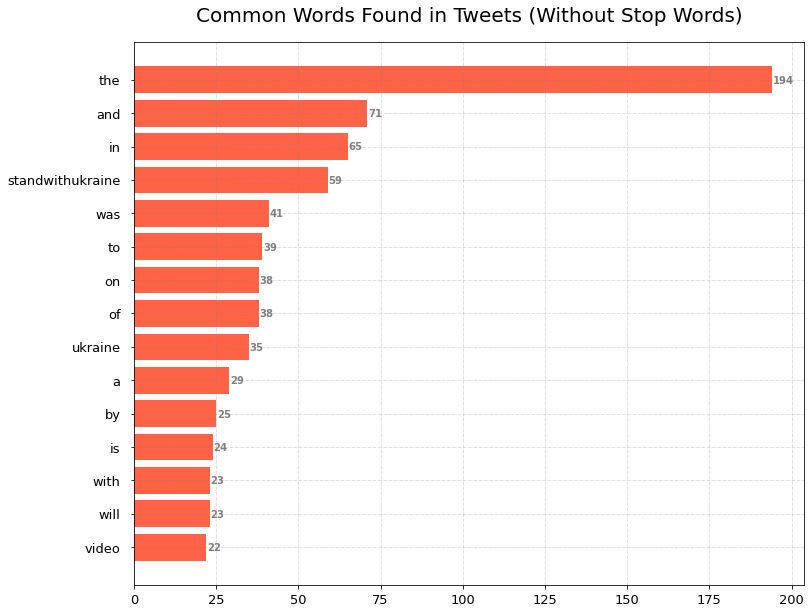

In [9]:
#Replace URLs and @mentions found in a text string with nothing
text_cleaned = tweetsDF['text'].str.replace(r'(@([^\s]+))|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', '', regex=True).str.strip()
words_in_tweet = [tweet.lower().split() for tweet in text_cleaned] # creating list of individual word from all tweets
words_in_tweet_list = list(itertools.chain(*words_in_tweet)) # flatten into 1 list

# Create counter
counts_words_before = collections.Counter(words_in_tweet_list)

# Creating a dataframe for words in tweets and word count, then sorting by descending order
df_counts_words_before = pd.DataFrame(counts_words_before.items(), columns=["words", "count"]).sort_values(by="count", ascending=False)

# retriving the 10 most common words in tweets
words = df_counts_words_before['words'].head(15)
counts = df_counts_words_before['count'].head(15)

# Figure Size
fig, ax = plt.subplots(figsize=(12, 10))

# Horizontal Bar Plot
ax.barh(words, counts, color='tomato')

# Add labels and padding between axes and labels
ax.xaxis.set_tick_params(pad=5, labelsize=13)
ax.yaxis.set_tick_params(pad=10, labelsize=13)


# Add x, y gridlines
ax.grid(visible=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.5)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Common Words Found in Tweets (Without Stop Words)', fontsize=20, pad=20)

plt.show()


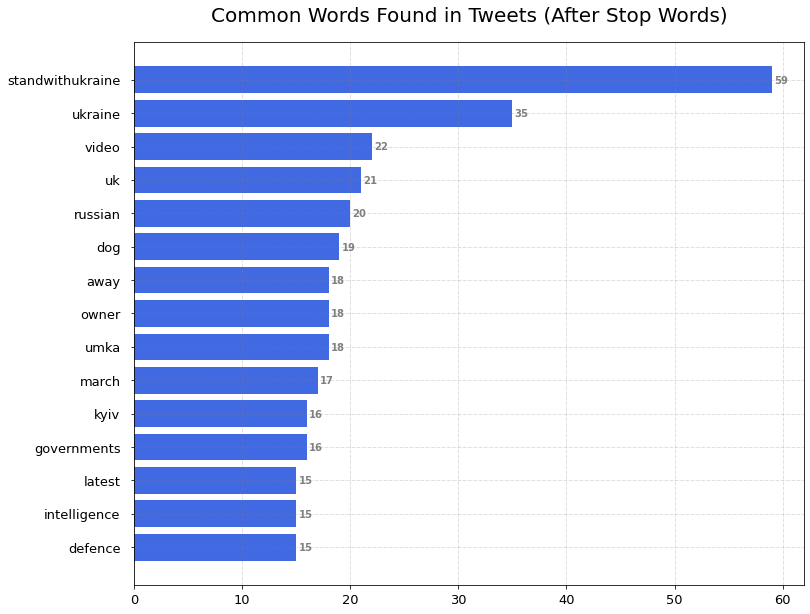

In [10]:
stop_words = set(stopwords.words('english')) # initialising stopwords / commonly used words
# removal of stopwords
tweets_nsw = [[word for word in tweet_words if word not in stop_words]
                for tweet_words in words_in_tweet]  # removing stopwords from list of individual words
all_words = list(itertools.chain(*tweets_nsw)) # flatten into 1 list


# Create counter
counts_words = collections.Counter(all_words)

# Creating a dataframe for words in tweets and word count, then sorting by descending order
df_counts_words_cleaned = pd.DataFrame(counts_words.items(), columns=["words", "count"]).sort_values(by="count", ascending=False)

# retriving the 10 most common words in tweets
words_cleaned = df_counts_words_cleaned['words'].head(15)
counts_cleaned = df_counts_words_cleaned['count'].head(15)

# Figure Size
fig, ax = plt.subplots(figsize=(12, 10))

# Horizontal Bar Plot
ax.barh(words_cleaned, counts_cleaned, color="royalblue")

# Add labels and padding between axes and labels
ax.xaxis.set_tick_params(pad=5, labelsize=13)
ax.yaxis.set_tick_params(pad=10, labelsize=13)


# Add x, y gridlines
ax.grid(visible=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.5)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Common Words Found in Tweets (After Stop Words)', fontsize=20, pad=20)

plt.show()


# Sentimental Analysis - Word Cloud

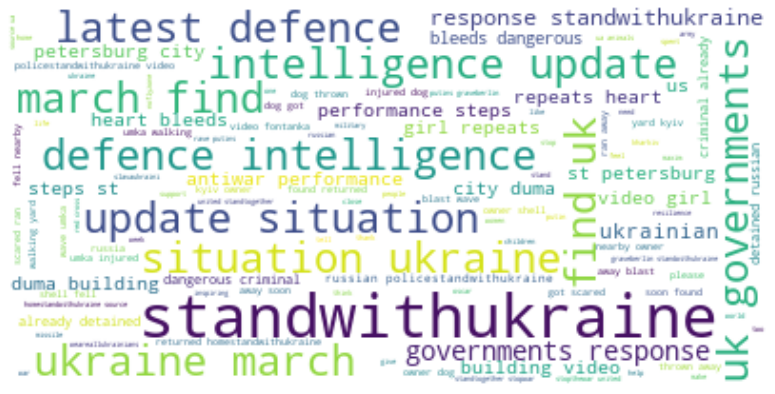

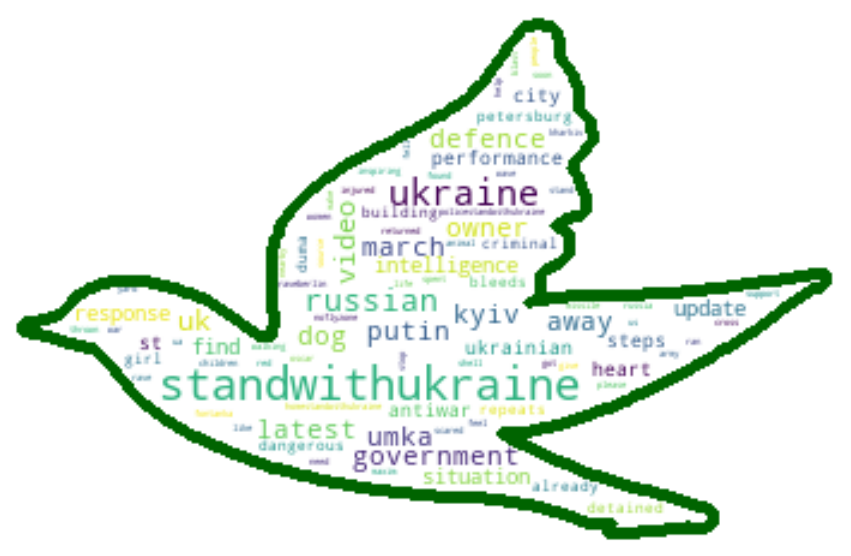

In [11]:
def word_cloud(tweetsDF):
    # Generate wordcloud
    wordcloud = WordCloud(font_step=1,
                            stopwords=stop_words, # removes any specified unwanted words
                            background_color='white').generate(' '.join(str(w) for w in all_words)) # collapse list to get string

    # Displays the image
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear') # interpolation used to display smoother image
    plt.axis("off")
    plt.show()

    # Generate a dove word cloud image
    dove_mask = np.array(Image.open("dove.jpg")) # Ref: https://python-course.eu/applications-python/python-wordcloud-tutorial.php
    wordcloud = WordCloud(font_step=1, 
                    stopwords=stop_words,
                    collocations=False,
                    background_color='white',
                    mask=dove_mask,
                    contour_width=5, 
                    contour_color='darkgreen'
                         ).generate(' '.join(str(v) for v in all_words))
    
    # Display dove image & store to file
    plt.figure(figsize=(15, 15))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("dove_out.jpg", format="jpg")
    plt.show()
word_cloud(tweetsDF)

# Sentimental Analysis - Polarity

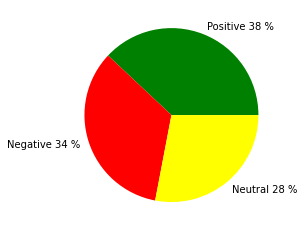

[38, 34, 28]


In [12]:
pos_tweets = 0   #count of positive tweets
neg_tweets = 0   #count of negative tweets
neu_tweets = 0   #count of neutral tweets
total_tweets = 0 #total count of tweets


for polarity in tweetsDF['polarity']:
        total_tweets = total_tweets + 1
        if polarity > 0:
            pos_tweets = pos_tweets + 1
        if polarity == 0:
            neu_tweets = neu_tweets + 1
        if polarity < 0:
            neg_tweets = neg_tweets + 1

tweets_count = [pos_tweets,
                 neg_tweets,
                 neu_tweets]

labels = [ "Positive " + str(round(pos_tweets / total_tweets * 100))+ " %",
            "Negative " + str(round(neg_tweets / total_tweets * 100)) + " %" ,
            "Neutral " + str(round(neu_tweets / total_tweets* 100)) + " %" ]

plt.pie( tweets_count,
labels=labels,
colors=['green','red','yellow']
)
plt.show()

print(tweets_count)